In [0]:
!unzip /content/classes.zip

Archive:  /content/classes.zip
error: End-of-centdir-64 signature not where expected (prepended bytes?)
  (attempting to process anyway)
warning [/content/classes.zip]:  16777216 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  16777216
  (attempting to re-compensate)
replace classes/1_1_11_1/1_1_11_1_127.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: classes/1_1_11_1/1_1_11_1_127.jpeg  
replace classes/1_1_11_1/1_1_11_1_126.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: classes/1_1_11_1/1_1_11_1_126.jpeg  
replace classes/1_1_11_1/1_1_11_1_125.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: classes/1_1_11_1/1_1_11_1_125.jpeg  
  inflating: classes/1_1_11_1/1_1_11_1_124.jpeg  
  inflating: classes/1_1_11_1/1_1_11_1_123.jpeg  
  inflating: classes/1_1_11_1/1_1_11_1_122.jpeg  
  inflating: classes/1_1_11_1/1_1_11_1_121.jpeg  
  inflating: classes/1_1_11_1/1_1_11_1_120.jpeg  


In [0]:
import cv2
import numpy as np
import os
from keras import Input
from keras import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.utils import plot_model
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras import backend as K
from PIL import Image

def getImageVariable(path):
	classFolder=path
	imageList=[]
	cnt=0
	tempArry=np.zeros((96000,5),int)

	for length in range(2):
		for width in range(2):
			for angle in range(12):
				for color in range(2):

					for variation in range(1000):
	
						tempArry[cnt,:]=[cnt,length,width,angle,color]
						cnt+=1
	np.random.shuffle(tempArry)

	
	for i in range(96000):
		string="/"+str(tempArry[i][1])+"_"+str(tempArry[i][2])+"_"+str(tempArry[i][3])+"_"+str(tempArry[i][4])
		imgFolder=classFolder+string
		img=imgFolder+string+"_"+str(tempArry[i][0]%1000)+".jpeg"
		imageList.append(cv2.imread(img))

	return imageList,tempArry[:,1],tempArry[:,2],tempArry[:,3],tempArry[:,4]


imagePath="/content/classes"                      # path to images
a, b, c, d, e = getImageVariable(imagePath)

In [0]:
# Single input and four output(classification heads)
# Test and train split
# First output length wise 0-7 and 1-15
# second output width wise 0-1 and 1-3
# third output color wise 0-red and 1-blue
# fourth output angle wise (0-180, diff=15) - (0-11)



# remember to normalize image array by dividing 255
# try out batch normalization before and after activation

input_train = np.array(a, dtype=np.float32)
input_train /= 255.0
print(input_train.shape)

output1_train = np.array(b)
output2_train = np.array(c)
print(output2_train.shape)
output3_train = np.array(e)
output4_train = np.array(d)

splitSz = input_train.shape[0]
endd = splitSz
splitSz = int(0.7*splitSz)

input_train, input_test = input_train[:splitSz,:], input_train[splitSz:endd,:]
output1_train, output1_test = output1_train[:splitSz], output1_train[splitSz:endd]
output2_train, output2_test = output2_train[:splitSz], output2_train[splitSz:endd]
output3_train, output3_test = output3_train[:splitSz], output3_train[splitSz:endd]
output4_train, output4_test = output4_train[:splitSz], output4_train[splitSz:endd]

(96000, 28, 28, 3)
(96000,)


In [0]:
inp = Input(shape=(28,28,3))

# Conv -> Conv -> Pool
x = Conv2D(32, (3,3), padding="same")(inp)

x = Activation("relu")(x)
x = BatchNormalization(name="conv1")(x)
x = Conv2D(32, (3,3), padding="same")(x)

x = Activation("relu")(x)
x = BatchNormalization(name="conv2")(x)
x = MaxPooling2D(pool_size=(2,2))(x)


# Conv -> Conv -> Pool
x = Conv2D(64, (3,3), padding="same")(x)

x = Activation("relu")(x)
x = BatchNormalization(name="conv3")(x)
x = Conv2D(64, (3,3), padding="same")(x)

x = Activation("relu")(x)
x = BatchNormalization(name="conv4")(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Flatten()(x)

# above is the shared layer and our x now
# is the feature map.
# x = (7, 7, 64)

# out1 corresponds to the length clasification head
out1 = Dense(1024)(x)
out1 = Activation("relu")(out1)
out1 = Dropout(0.5)(out1)
# out1 = Dense(1024)(out1)
# out1 = Activation("relu")(out1)
# out1 = Dropout(0.3)(out1)
out1 = Dense(1)(out1)
out1 = Activation("sigmoid", name="out1")(out1)

# out2 corresponds to the width clasification head
out2 = Dense(1024)(x)
out2 = Activation("relu")(out2)
out2 = Dropout(0.5)(out2)
# out2 = Dense(1024)(out2)
# out2 = Activation("relu")(out2)
# out2 = Dropout(0.5)(out2)
out2 = Dense(1)(out2)
out2 = Activation("sigmoid", name="out2")(out2)

# out3 corresponds to the color clasification head
out3 = Dense(1024)(x)
out3 = Activation("relu")(out3)
out3 = Dropout(0.5)(out3)
# out3 = Dense(1024)(out3)
# out3 = Activation("relu")(out3)
# out3 = Dropout(0.5)(out3)
out3 = Dense(1)(out3)
out3 = Activation("sigmoid", name="out3")(out3)

# out4 corresponds 
out4 = Dense(1024)(x)
out4 = Activation("relu")(out4)
# out4 = Dropout(0.2)(out4)
# out4 = Dense(1024)(out4)
# out4 = Activation("relu")(out4)
# out4 = Dropout(0.2)(out4)
out4 = Dense(12)(out4)
out4 = Activation("softmax", name="out4")(out4)

# final model with one input and four classification heads
model = Model(inputs=[inp], outputs=[out1, out2, out3, out4])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 28, 28, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv1 (BatchNormalization)      (None, 28, 28, 32)   128         activation_9[0][0]               
__________________________________________________________________________________________________
conv2d_6 (

In [0]:
model.compile(optimizer='adam', loss={'out1': 'binary_crossentropy', 'out2': 'binary_crossentropy', 'out3': 'binary_crossentropy', 'out4': 'sparse_categorical_crossentropy'}, metrics=['accuracy'])
model.fit([input_train], {'out1': output1_train, 'out2': output2_train, 'out3': output3_train, 'out4': output4_train}, epochs=3, batch_size=128)


Epoch 1/3
67200/67200 [==============================] - 35s 519us/step - loss: 0.7049 - out1_loss: 0.2354 - out2_loss: 0.0778 - out3_loss: 0.0149 - out4_loss: 0.3768 - out1_acc: 0.9758 - out2_acc: 0.9852 - out3_acc: 0.9979 - out4_acc: 0.8983
Epoch 2/3
67200/67200 [==============================] - 31s 463us/step - loss: 0.0312 - out1_loss: 0.0019 - out2_loss: 0.0024 - out3_loss: 0.0020 - out4_loss: 0.0249 - out1_acc: 0.9993 - out2_acc: 0.9992 - out3_acc: 0.9996 - out4_acc: 0.9930
Epoch 3/3
67200/67200 [==============================] - 31s 466us/step - loss: 0.0393 - out1_loss: 0.0052 - out2_loss: 0.0055 - out3_loss: 6.3930e-04 - out4_loss: 0.0280 - out1_acc: 0.9991 - out2_acc: 0.9988 - out3_acc: 0.9999 - out4_acc: 0.9909


In [0]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
x = input_test[311]
print(x.shape)
activations = activation_model.predict(x.reshape(1,28,28,3))

plt.figure()
plt.imshow(x)
plt.grid(False)
plt.axis('off')
# plt.set_yticklabels([])
# plt.set_xticklabels([])
# plt.show()
plt.savefig('img.png')
 
def display_activation(activations, col_size, row_size, act_index): 
    size = activations[0].shape[1]
    scale = 1. / size
    activation = activations[act_index]
    activation_index=0
    plt.figure()
    
    fig, ax = plt.subplots(row_size, col_size, figsize=(24,10))
    fig.suptitle('Activation Map', fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].grid(False)
            ax[row][col].set_yticklabels([])
            ax[row][col].set_xticklabels([])

            im = ax[row][col].imshow(activation[0, :, :, activation_index], cmap='jet', aspect='auto')
            activation_index += 1
#     plt.colorbar()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.10, 0.01, 0.8])
    fig.colorbar(im, cax=cbar_ax, aspect=10)

    plt.savefig('abc.png')
# activations.shape
display_activation(activations, 8, 4 ,0 )

(28, 28, 3)


InvalidArgumentError: ignored

In [0]:
def decodeImg(y):
  '''function to convert a float array into 
     a valid unit8 image '''
  
  # normalizing the input
  y -= y.mean()
  y /= (y.std() + K.epsilon())
  y *= 0.25
  
  # clipping to [0,1]
  y += 0.5
  y = np.clip(y, 0, 1)
  
  # converting to RGB array
  y *= 255
  y = np.clip(y, 0, 255).astype('uint8')
  return y

# visualization for convolutional filters

def visualizeFilter(filterNum, imSize=28, epochs=20, alpha=0.1):
  
  layerOutput = model.get_layer(layerName).output
  
  # to maximize the output of the corresponding filter
  loss = K.mean(layerOutput[:,:,:,filterNum])
  
  # computing gradient wrt to each input pixel
  # it is list of tensor so applied the indexing
  gradients = K.gradients(loss, model.input)[0]
  
  # normalizing the gradients
  gradients /= (K.sqrt(K.mean(K.square(gradients))) + K.epsilon())

  loopOver = K.function([model.input], [loss, gradients])
  
#   inpImage = (np.random.random((1, imSize, imSize, 3)) - 0.5) * 20 + 128
  inpImage = np.zeros((1, imSize, imSize, 3))
  
  for _ in range(epochs):
    lossVal, gradVal = loopOver([inpImage])
    inpImage += gradVal * alpha

  # taking in the actual image size
  return decodeImg(inpImage[0]), lossVal

def makeVisualization(filters, n=None):
  '''plot the visualizations of the filters'''
  
  if n is None:
    n = int(np.floor(np.sqrt(len(filters))))
    
  filters.sort(key=lambda x: x[1], reverse=True)
  filters = filters[:n * n]
  
  MARGIN = 3
  width = n * dim + (n - 1) * MARGIN
  height = n * dim + (n - 1) * MARGIN
  
  # making a black image and then paste our visualizations onto that
  allFilters = np.zeros((width, height, 3), dtype='uint8')
  
  # filling the above with our visualizations
  for i in range(n):
    for j in range(n):
      img, _ = filters[i * n + j]
      widthMargin = (dim + MARGIN) * i
      heightMargin = (dim + MARGIN) * j
      
      allFilters[
          widthMargin: widthMargin + dim,
          heightMargin: heightMargin + dim, :] = img
  
  allFilters[:, :, 0], allFilters[:, :, 2] = allFilters[:, :, 2], allFilters[:, :, 0]
  vis = Image.fromarray(allFilters, 'RGB')
  vis.save('visualize.png')
  vis.show()
  
layerName = 'conv4'
# inputImg = model.inputs[0]
# print(inputImg.op.type)
# layerDict = dict([(layer.name, layer) for layer in model.layers[1:]])
# outputLayer = layerDict[layerName]
# print(outputLayer.output.shape)

processedFilters = []
for fl in range(model.get_layer(layerName).output.shape[-1]):
  imgLoss = visualizeFilter(fl)
  
  if imgLoss is not None:
    processedFilters.append(imgLoss)

dim = 28
makeVisualization(processedFilters)
    

(?, 12)
(1, 28, 28, 3)


<Figure size 576x396 with 0 Axes>

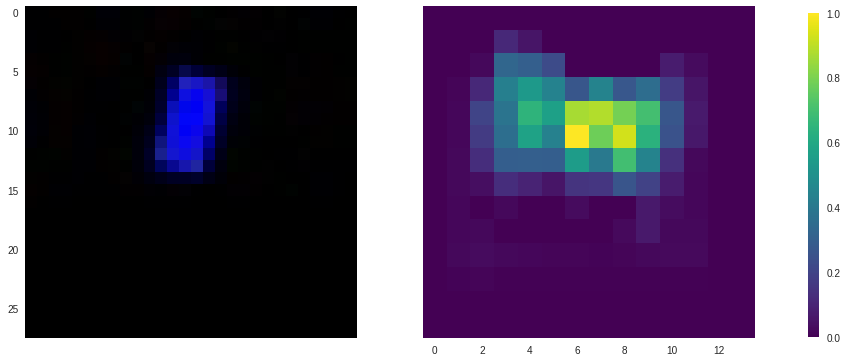

In [50]:
import matplotlib.pyplot as plt
imgPath = "/content/classes/0_1_5_0/0_1_5_0_20.jpeg"

# z is a float32 Numpy array of shape (28, 28, 3)
z = cv2.imread(imgPath)

# adding a dimension to transform the array into a batch
z = np.expand_dims(z, axis=0)
z = np.array(z, dtype=np.float32)
z /= 255.0

preds = model.predict(z)
# print(preds)

# pass the class here
lineOutput = model.outputs[3][:,]
print(lineOutput.shape)

# gradient of one of the output class wrt to the output feature map of the given layer
grads = K.gradients(lineOutput, model.get_layer(layerName).output)[0]

# print(grads.shape)

# return the mean intensity of the gradient over a specific feature map channel
pooledGrads = K.mean(grads, axis=(0,1,2))

# print(pooledGrads)

# below function allows to access the values of pooledGrads and the output feature map
# given a image
iterate = K.function([model.input], [pooledGrads, model.get_layer(layerName).output[0]])

# get the value for the given input
pooledValue, convOutput = iterate([z])

# print(pooledValue)

# multiplying each channel(filter) in the feature map array by 'how
# important the channel is with reagrd to given class'
for i in range(model.get_layer(layerName).output.shape[-1]):
  convOutput[:, :, i] *= pooledValue[i]
  
# channel wise mean of the resulting feature map
heatmap = np.mean(convOutput, axis=-1)

# for visualization normalizing the value b/w 0 and 1
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(15,15))
# plt.grid(False)
ax[1].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].grid(False)
ax[0].grid(False)

print(z.shape)
im = ax[1].imshow(heatmap, cmap="viridis")
ax[0].imshow(z.squeeze())
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.3])
fig.colorbar(im, cax=cbar_ax, aspect=10)

plt.savefig("yo.png")
# plt.show(heatmap)